# Interpreting CNN Results

In this tutorial, we will create a model to distinguish images from Alzheimer's patients and normal subjects. Then, we will employ a method called GRAD-CAM to try to interpret the results and arrive to a conclusion on whether the results make sense or not.


In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from skimage.transform import resize

In [2]:
# Loading the datasets
ad = np.load("../Data/Alzheimer/alzheimer_4_slices_240_180_philips_3t.npy") # Alzheimer's
normal = np.load("../Data/Alzheimer/normal_4_slices_256_212_ge_3t.npy") # Normal

# Padding images to the same dimensions
new_dims = 256,256
ad_resized = np.zeros((ad.shape[0],new_dims[0],new_dims[1]), dtype = np.float32)
ad_resized[:,:ad.shape[1],:ad.shape[2]] = ad

normal_resized = np.zeros((normal.shape[0],new_dims[0],new_dims[1]), dtype = np.float32)
normal_resized[:,:normal.shape[1],:normal.shape[2]] = normal

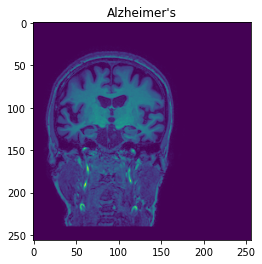

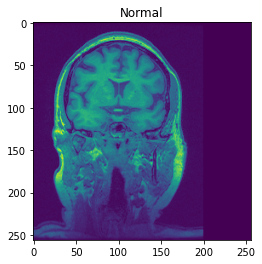

In [3]:
plt.figure()
plt.imshow(ad_resized[10])
plt.title("Alzheimer's")
plt.show()

plt.figure()
plt.imshow(normal_resized[10])
plt.title("Normal")
plt.show()

In [4]:
# Concatenating the data
X = np.concatenate((normal_resized,ad_resized), axis = 0)
Y = np.zeros(X.shape[0])
Y[Y.shape[0]//2:] = 1

# Train/Validation/Test split
nslices = 4
indexes = np.arange(Y.shape[0]//nslices, dtype = int)
np.random.shuffle(indexes)
train = indexes[:int(0.6*indexes.shape[0])]*nslices
train = np.repeat(train,nslices).reshape(-1,nslices) + np.arange(nslices)# 60%
val = indexes[int(0.6*indexes.shape[0]):int(0.8*indexes.shape[0])]*nslices # 20%
val = np.repeat(val,nslices).reshape(-1,nslices) + np.arange(nslices)
test = indexes[int(0.8*indexes.shape[0]):]*nslices # 20%
test = np.repeat(test,nslices).reshape(-1,nslices) + np.arange(nslices)
train = train.flatten()
val = val.flatten()
test = test.flatten()

# Train and validation split
X_train = X[train]
Y_train = Y[train]
X_val =  X[val]
Y_val = Y[val]
X_test = X[test]
Y_test = Y[test]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (288, 256, 256)
Labels shape:  (288,)

Validation set
Images:  (96, 256, 256)
Labels shape:  (96,)


In [5]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0.0 1.0 0.10193799 0.1352274
0.0 1.0 0.10122881 0.13367295


In [6]:
# Defining a simple CNN model
ishape = (256,256,1)
lr = 1e-3
model_input = tf.keras.layers.Input(shape = ishape)
l1 = tf.keras.layers.Conv2D(48, (3,3), padding = 'same', activation='relu')(model_input)
l2 = tf.keras.layers.Conv2D(48, (3,3), padding = 'same', activation='relu')(l1)
l2_drop = tf.keras.layers.Dropout(0.3)(l2)
l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)

l4 = tf.keras.layers.Conv2D(96, (3,3), padding = 'same', activation='relu')(l3)
l5 = tf.keras.layers.Conv2D(96, (3,3), padding = 'same', activation='relu')(l4)
l5_drop = tf.keras.layers.Dropout(0.5)(l5)
l6 = tf.keras.layers.MaxPool2D((2,2))(l5_drop)

l7 = tf.keras.layers.Conv2D(192, (3,3), padding = 'same', activation='relu')(l6)
l8 = tf.keras.layers.Conv2D(192, (3,3), padding = 'same', activation='relu')(l7)
l8_drop = tf.keras.layers.Dropout(0.5)(l8)
l9 = tf.keras.layers.MaxPool2D((2,2))(l8_drop)

l10 = tf.keras.layers.Conv2D(384, (3,3), padding = 'same', activation='relu')(l9)
l11 = tf.keras.layers.Conv2D(384, (3,3), padding = 'same', activation='relu')(l10)
l11_drop = tf.keras.layers.Dropout(0.3)(l11)


flat = tf.keras.layers.Flatten()(l11_drop)

out = tf.keras.layers.Dense(1,activation = 'sigmoid')(flat)

model = tf.keras.models.Model(inputs = model_input, outputs = out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 48)      480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 48)      20784     
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 48)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 48)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 96)      41568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 96)      83040 

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss = "binary_crossentropy", metrics = ["accuracy"])

In [8]:
model_name = "best_model_alzheimer_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [9]:
model.fit(X_train[:,:,:,np.newaxis],Y_train,batch_size = 64, epochs = 25, \
          verbose = 1, callbacks= [early_stop, monitor],validation_data=(X_val[:,:,:,np.newaxis],Y_val), shuffle  = True)

Epoch 1/25
5/5 [==============================] - 123s 15s/step - loss: 0.7652 - accuracy: 0.4778 - val_loss: 0.6432 - val_accuracy: 0.6250
Epoch 2/25
5/5 [==============================] - 2s 319ms/step - loss: 1.4246 - accuracy: 0.6798 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 2s 319ms/step - loss: 0.6798 - accuracy: 0.4796 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 2s 317ms/step - loss: 0.6637 - accuracy: 0.5563 - val_loss: 0.6789 - val_accuracy: 0.8750
Epoch 5/25
5/5 [==============================] - 2s 319ms/step - loss: 0.3734 - accuracy: 0.8738 - val_loss: 0.3315 - val_accuracy: 0.8438
Epoch 6/25
5/5 [==============================] - 2s 318ms/step - loss: 0.5738 - accuracy: 0.9121 - val_loss: 0.6102 - val_accuracy: 0.5417
Epoch 7/25
5/5 [==============================] - 2s 341ms/step - loss: 0.1079 - accuracy: 0.9706 - val_loss: 0.1978 - val_accuracy: 0.9583
Epoch 8/25
5/5 [====

In [10]:
model.load_weights(model_name)
metrics = model.evaluate(X_test[:,:,:,np.newaxis],Y_test)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

3/3 [==============================] - 0s 41ms/step - loss: 0.0759 - accuracy: 0.9583
Categorical cross-entropy: 0.07591771334409714
Accuracy: 0.9583333134651184


In [11]:
LAYER_NAME='conv2d_7'
#grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output,
                                                    model.output])
3grad_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 48)      480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 48)      20784     
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 48)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 48)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 96)      41568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 96)      8304

In [12]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]
        

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(256, 256))
    return heatmap_resized

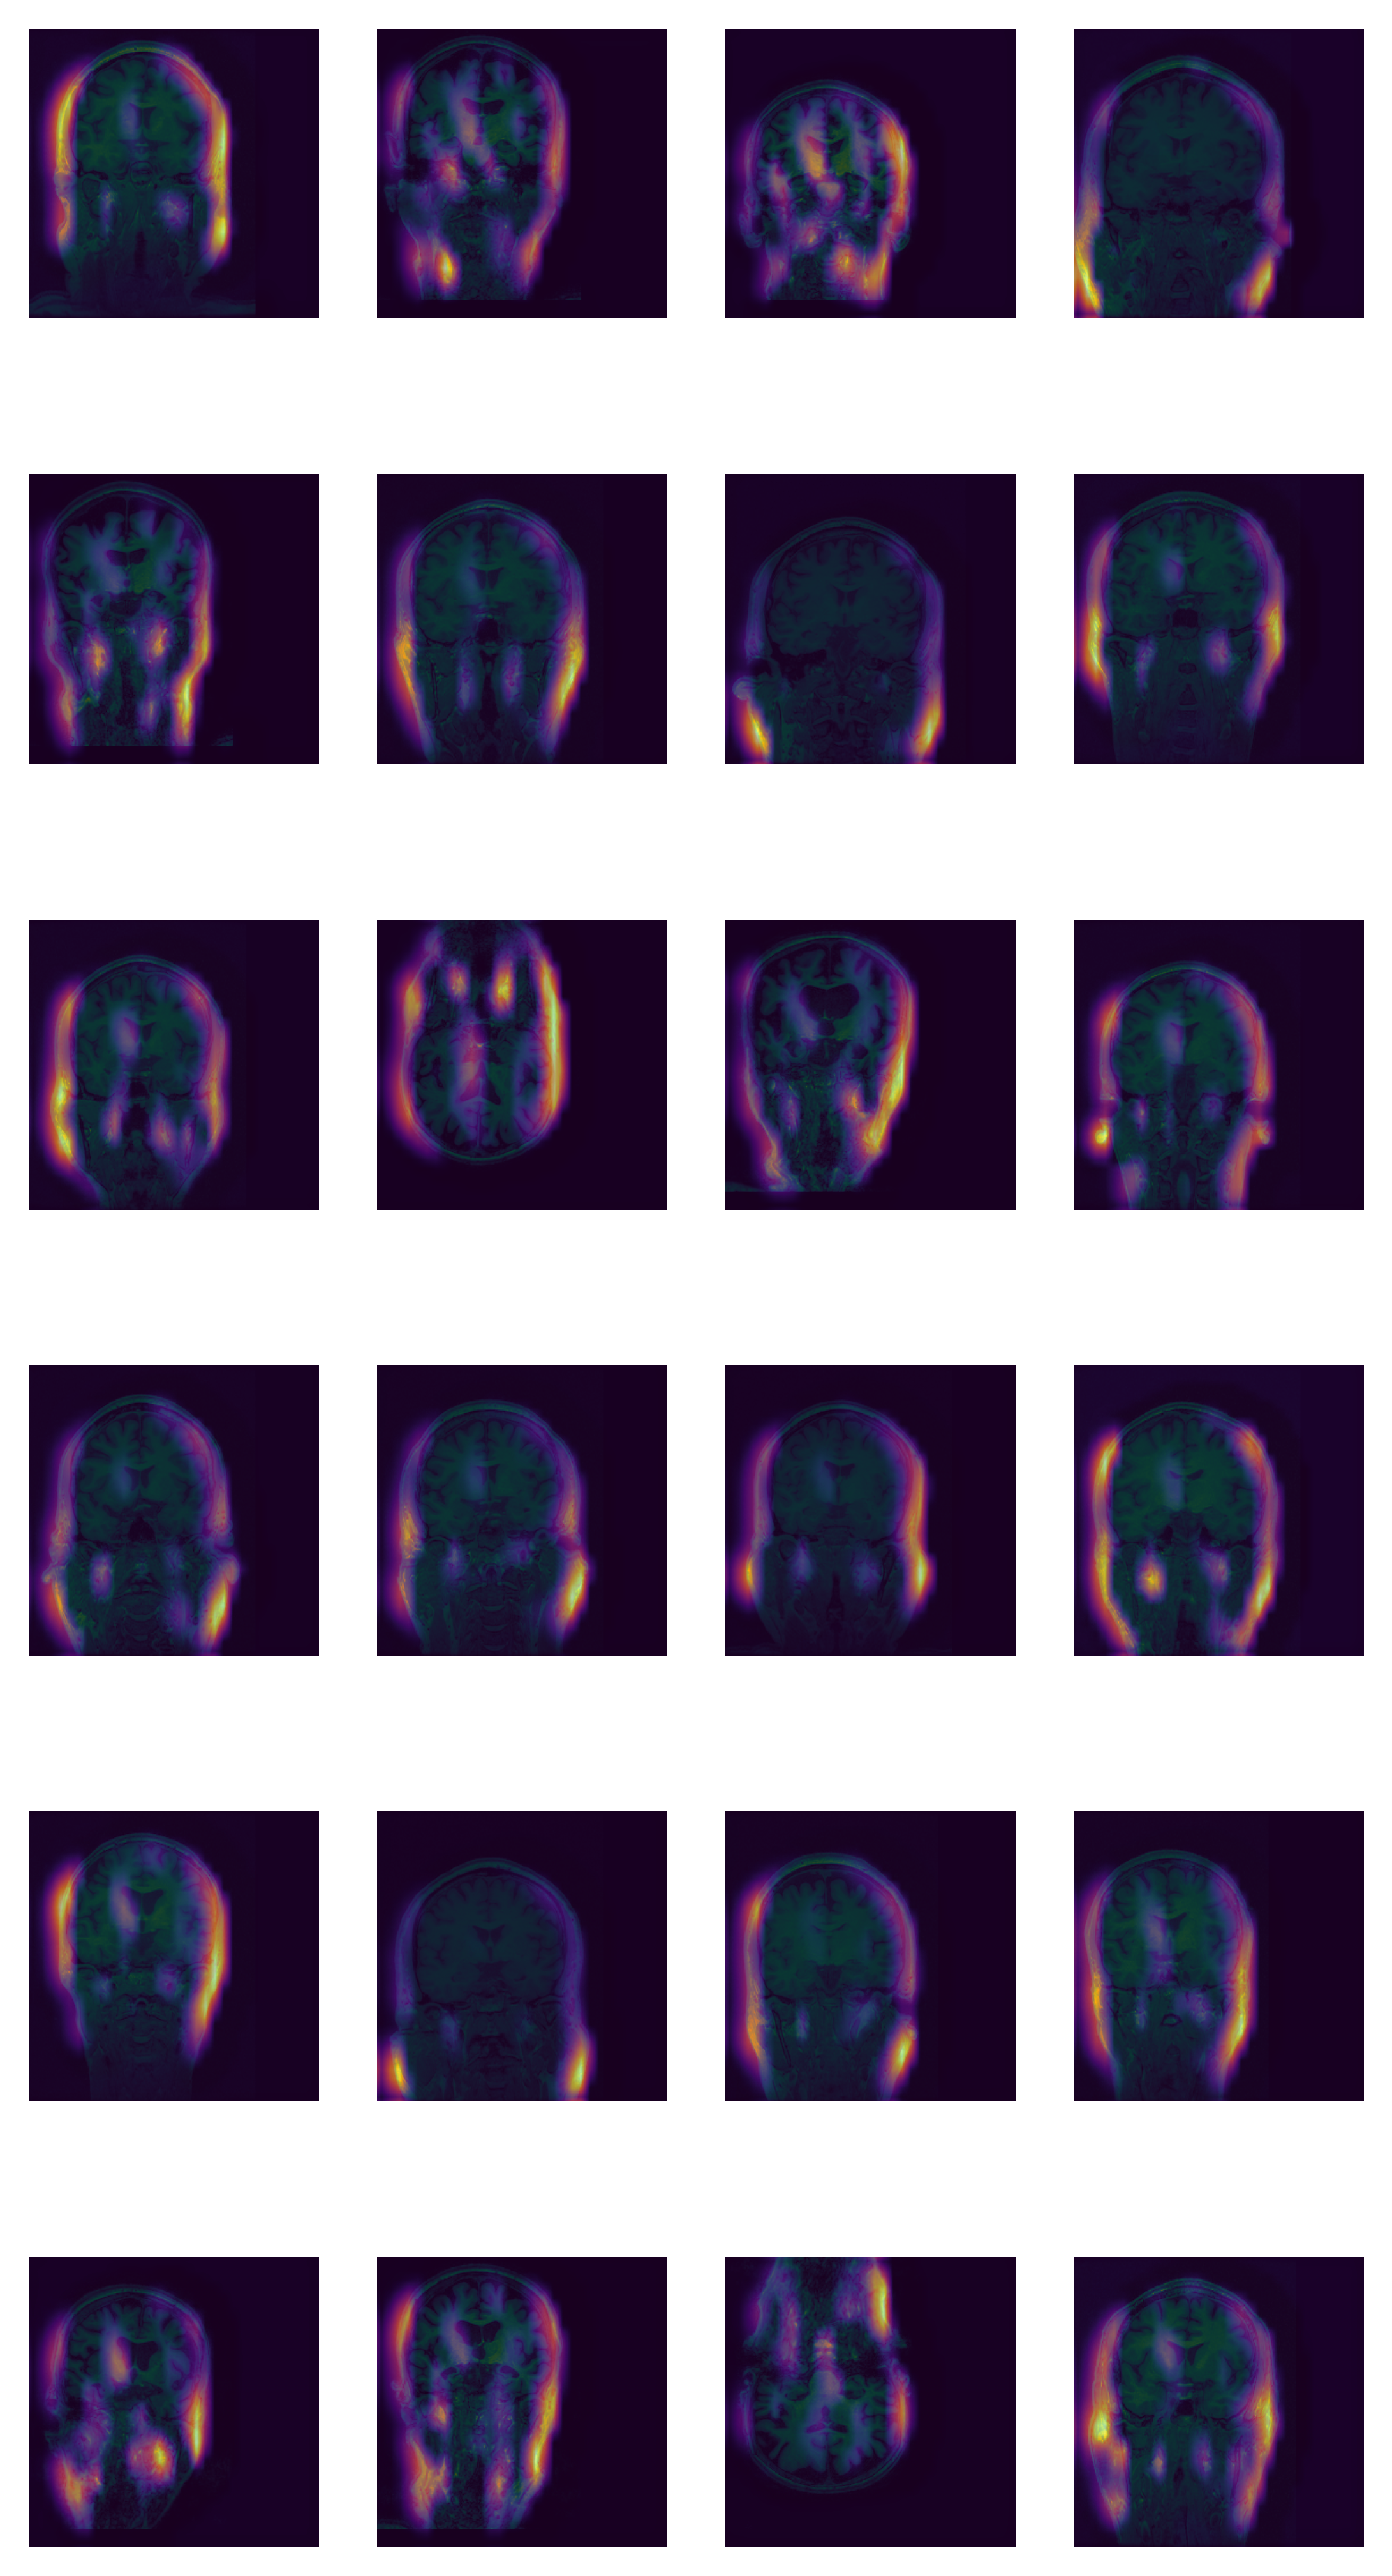

In [13]:
# Remove last layer's sigmoid
model.layers[-1].activation = None


plt.figure(figsize = (6,12),dpi = 450)

for ii in range(X_test.shape[0]//4):
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(X_test[ii*4][np.newaxis,:,:,np.newaxis], model, "conv2d_7")
    plt.subplot(6,4,ii+1)
    plt.imshow(X_test[ii*4])
    plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
    #plt.colorbar()
    plt.axis("off")
plt.show()